In [1]:
import numpy as np
from time import time
import os
import sys
import scipy
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from scipy.interpolate import interp1d
import pandas as pd
import psutil
import scipy as sp
import scipy.ndimage
from tqdm import tqdm
sys.path.insert(0, '/home/users/brezovec/.local/lib/python3.6/site-packages/lib/python/')
import ants
import bigbadbrain as bbb
from scipy.linalg import toeplitz
import scipy.linalg as sl
from scipy.signal import convolve2d
from scipy.signal import convolve
import sklearn
from sklearn.linear_model import LassoLarsIC
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.model_selection import KFold
from sklearn.feature_selection import RFE
from sklearn import linear_model

from skimage.filters import threshold_triangle
sys.path.insert(0, '/home/users/brezovec/.local/lib/python3.6/site-packages')
import cv2

import statsmodels.api as sm

%matplotlib inline

In [57]:
directory = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset/fly_25/func_0'

In [58]:
brain_path = os.path.join(directory, 'brain_zscored_green.nii')
brain = bbb.load_numpy_brain(brain_path)
dims = bbb.get_dims(brain)
print('brain shape is x,y,z,t {}'.format(brain.shape))


~~ load_numpy_brain ~~
load_numpy_brain done. Duration: 17.45 sec
brain shape is x,y,z,t (128, 92, 51, 4128)


In [59]:
timestamps = bbb.load_timestamps(os.path.join(directory, 'imaging'))
fictrac = bbb.load_fictrac(os.path.join(directory, 'fictrac'))


~~ load_timestamps ~~
Trying to load timestamp data from hdf5 file.
Success.
load_timestamps done. Duration: 56.78 ms

~~ load_fictrac ~~
load_fictrac done. Duration: 3.23 sec


In [60]:
t0 = time()
save_file = os.path.join(directory, 'pca', 'scores_(spatial).npy')
pca_spatial = np.load(save_file)
save_file = os.path.join(directory, 'pca', 'loadings_(temporal).npy')
pca_loadings = np.load(save_file)
print('Duration: {}'.format(time()-t0))

Duration: 26.47579526901245


In [61]:
def interp_fictrac(fictrac, behavior, fps, resolution, expt_len, timestamps, interp_to):
    camera_rate = 1/fps * 1000 # camera frame rate in ms
    sphere_radius = 4.5e-3
    filter_window = 51
    
    x_original = np.arange(0,expt_len,camera_rate)
    
    if behavior == 'all':
        dx = np.asarray(fictrac['dRotLabX'])
        dy = np.asarray(fictrac['dRotLabY'])
        dz = np.asarray(fictrac['dRotLabZ'])
        dx = scipy.signal.savgol_filter(dx,filter_window,3) * sphere_radius * 50 * 100 * 10
        dy = scipy.signal.savgol_filter(dy,filter_window,3) * sphere_radius * 50 * 100 * 10
        dz = scipy.signal.savgol_filter(dz,filter_window,3) * 180 / np.pi * 50
        fictrac_smoothed = np.sqrt(dx*dx + dy*dy + dz*dz)
    elif behavior == 'Y':
        dy = np.asarray(fictrac['dRotLabY'])
        fictrac_smoothed = scipy.signal.savgol_filter(dy,filter_window,3) * sphere_radius * 50 * 100 * 10
    elif behavior == 'Z':
        dz = np.asarray(fictrac['dRotLabZ'])
        fictrac_smoothed = scipy.signal.savgol_filter(dz,filter_window,3) * 180 / np.pi * 50
    else:
        print('invalid behavior')
    
    #fictrac_smoothed = np.abs(fictrac_smoothed)
    fictrac_interp_temp = interp1d(x_original, fictrac_smoothed, bounds_error = False)
    xnew = np.arange(0,expt_len,resolution) #0 to last time at subsample res
    
    if interp_to is 'timestamps':
        fictrac_interp = fictrac_interp_temp(timestamps[:,25])
    elif interp_to is 'xnew':
        fictrac_interp = fictrac_interp_temp(xnew)
    else:
        print('Invalid interp_to ({})'.format(interp_to))

    # Replace Nans with zeros (for later code)
    np.nan_to_num(fictrac_interp, copy=False);
    
    return fictrac_interp

In [62]:
resolution = 50 #desired resolution in ms
expt_len = 1000*30*60
fps = 50 #of fictrac camera
xnew = np.arange(0,expt_len,resolution)

fictracs_high_res = {}
for behavior in ['all', 'Y', 'Z']:
    fictracs_high_res[behavior] = interp_fictrac(fictrac, behavior, fps, resolution, expt_len, timestamps, 'xnew')

fictracs = {}
for behavior in ['all', 'Y', 'Z']:
    fictracs[behavior] = interp_fictrac(fictrac, behavior, fps, resolution, expt_len, timestamps, 'timestamps')

Text(0.5, 1.0, 'Brain interp space zoom')

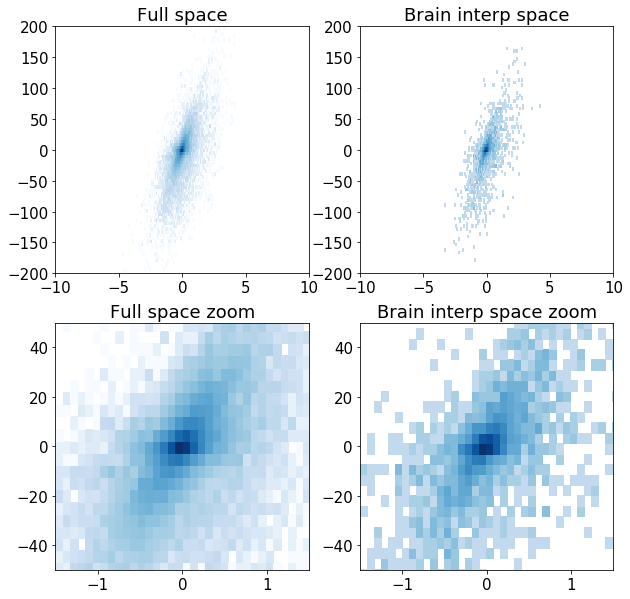

In [63]:
plt.figure(figsize=(10,10))
#norm = None
norm = mpl.colors.LogNorm()
#norm = mpl.colors.PowerNorm(.2)

plt.subplot(221)
plt.hist2d(fictracs_high_res['Y'],fictracs_high_res['Z'],bins=100,cmap='Blues',norm=norm);
plt.ylim(-200,200)
plt.xlim(-10,10)
plt.title('Full space')

plt.subplot(222)
plt.hist2d(np.repeat(fictracs['Y'],10),
           np.repeat(fictracs['Z'],10),
           bins=100,cmap='Blues',norm=norm);
plt.ylim(-200,200)
plt.xlim(-10,10)
plt.title('Brain interp space')

plt.subplot(223)
plt.hist2d(fictracs_high_res['Y'],fictracs_high_res['Z'],bins=100,cmap='Blues',norm=norm);
plt.ylim(-50,50)
plt.xlim(-1.5,1.5)
plt.title('Full space zoom')

plt.subplot(224)
h = plt.hist2d(np.repeat(fictracs['Y'],10),
           np.repeat(fictracs['Z'],10),
           bins=100,cmap='Blues',norm=norm);
plt.ylim(-50,50)
plt.xlim(-1.5,1.5)
plt.title('Brain interp space zoom')

In [64]:
pca_loadings_std = np.std(pca_loadings,axis=0)
pca_loadings= np.divide(pca_loadings,pca_loadings_std)

(0, 500)

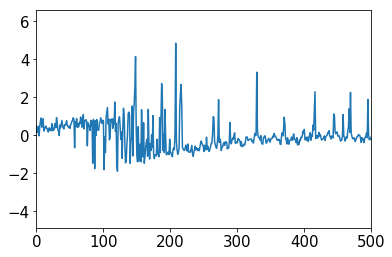

In [49]:
plt.plot(np.divide(pca_loadings,pca_loadings_std)[:,1])
plt.xlim(0,500)

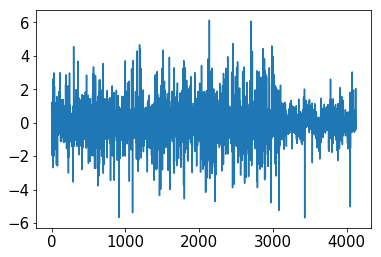

In [71]:
plt.plot(pca_loadings[:,1000])
#plt.xlim(0,500)

In [33]:
test = np.ones((100,10))

In [37]:
np.shape(pca_loadings_std)

(10,)

In [ ]:
# columns are PCs
# we want same # of columns


In [72]:
#### Predict behavior ####

models_Y = []
behavior = 'Y'
for num_pcs in [10,25,50,75,100,200,300,500]:
    Y_glm = fictracs[behavior]
    t0 = time()
    models_Y.append({'num_pcs': num_pcs, 'model': LassoLarsIC(criterion='bic')})
    X_glm = pca_loadings[:,:num_pcs]
    models_Y[-1]['model'].fit(X_glm, Y_glm)
    models_Y[-1]['score'] = models_Y[-1]['model'].score(X_glm, Y_glm)
    print('Num PCs: {}, Duration: {} sec'.format(num_pcs, time()-t0))

Num PCs: 10, Duration: 0.012684345245361328 sec
Num PCs: 25, Duration: 0.008139371871948242 sec
Num PCs: 50, Duration: 0.015443086624145508 sec
Num PCs: 75, Duration: 0.02281665802001953 sec
Num PCs: 100, Duration: 0.03149914741516113 sec
Num PCs: 200, Duration: 0.07468461990356445 sec
Num PCs: 300, Duration: 0.1560499668121338 sec
Num PCs: 500, Duration: 0.43004679679870605 sec


In [73]:
#### Predict behavior ####

models_Z = []
behavior = 'Z'
for num_pcs in [10,25,50,75,100,200,300,500]:
    Y_glm = fictracs[behavior]
    t0 = time()
    models_Z.append({'num_pcs': num_pcs, 'model': LassoLarsIC(criterion='bic')})
    X_glm = pca_loadings[:,:num_pcs]
    models_Z[-1]['model'].fit(X_glm, Y_glm)
    models_Z[-1]['score'] = models_Z[-1]['model'].score(X_glm, Y_glm)
    print('Num PCs: {}, Duration: {} sec'.format(num_pcs, time()-t0))

Num PCs: 10, Duration: 0.005292654037475586 sec
Num PCs: 25, Duration: 0.008127450942993164 sec
Num PCs: 50, Duration: 0.015113353729248047 sec
Num PCs: 75, Duration: 0.022545576095581055 sec
Num PCs: 100, Duration: 0.031641244888305664 sec
Num PCs: 200, Duration: 0.07782435417175293 sec
Num PCs: 300, Duration: 0.1585538387298584 sec
Num PCs: 500, Duration: 0.42711925506591797 sec


Text(0.5, 0.98, 'Regularization: LassoLarsIC(BIC)')

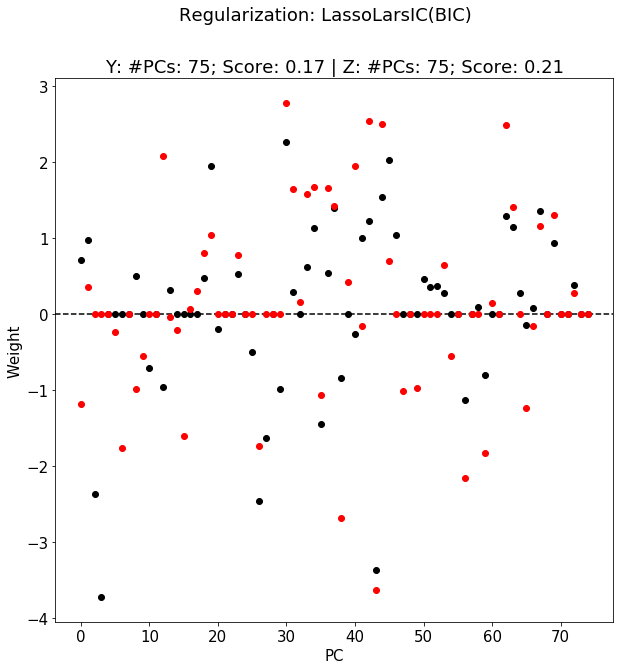

In [86]:
plt.figure(figsize=(10,10))

model_num = 3
plt.axhline(0,color='k',linestyle='--')
plt.plot(models_Y[model_num]['model'].coef_*50,'o',color='k')
plt.plot(models_Z[model_num]['model'].coef_,'o',color='r')
plt.title ('Y: #PCs: {}; Score: {:.2f} | Z: #PCs: {}; Score: {:.2f}'.format(models_Y[model_num]['num_pcs'],
                                                                            models_Y[model_num]['score'],
                                                                            models_Z[model_num]['num_pcs'],
                                                                            models_Z[model_num]['score']))
#for i in top_10:
#    plt.axvline(i,linestyle='--',color='k')
plt.ylabel('Weight')
plt.xlabel('PC')
    
plt.suptitle('Regularization: LassoLarsIC(BIC)')

In [12]:
Y_coef = models_Y[3]['model'].coef_
Z_coef = models_Z[3]['model'].coef_

In [13]:
Y_coef = np.divide(Y_coef, np.std(Y_coef))
Z_coef = np.divide(Z_coef, np.std(Z_coef))

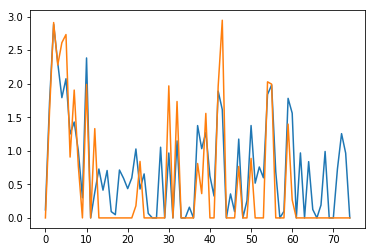

In [14]:
plt.plot(abs(Y_coef))
plt.plot(abs(Z_coef))

In [15]:
np.mean(Z_coef)

-0.12015358518543046

NameError: name 'models' is not defined

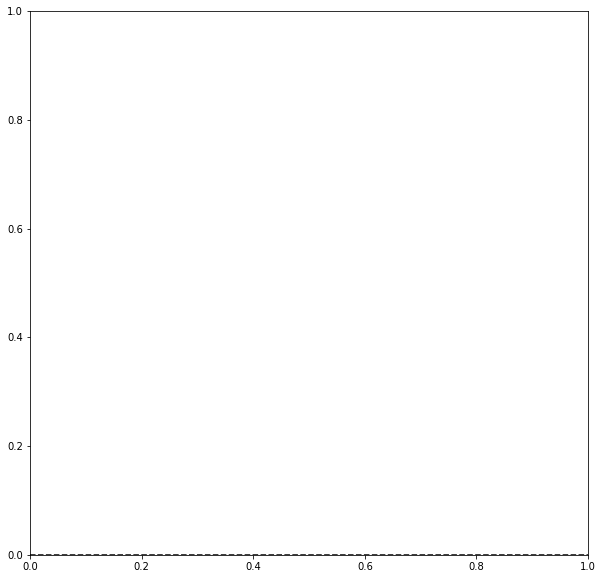

In [16]:
plt.figure(figsize=(10,10))

model_num = 2
plt.axhline(0,color='k',linestyle='--')
plt.plot(models[model_num]['model'].coef_,'o')
plt.title ('#PCs: {}; Score: {:.2f}'.format(models[model_num]['num_pcs'], models[model_num]['score']))
#for i in top_10:
#    plt.axvline(i,linestyle='--',color='k')
plt.ylabel('Weight')
plt.xlabel('PC')
    
plt.suptitle('Regularization: LassoLarsIC(BIC)')

In [96]:
X_glm = pca_loadings[:,:100]

#models[1]['model'].predict(pca_loadings[:,:100])

predicted_behavior = models[1]['model'].predict(X_glm)
interp_temp = interp1d(timestamps[:,25], predicted_behavior, bounds_error = False)
xnew = np.arange(0,expt_len,resolution) #0 to last time at subsample res
predicted_behavior_interp = interp_temp(xnew)

(1500, 2000)

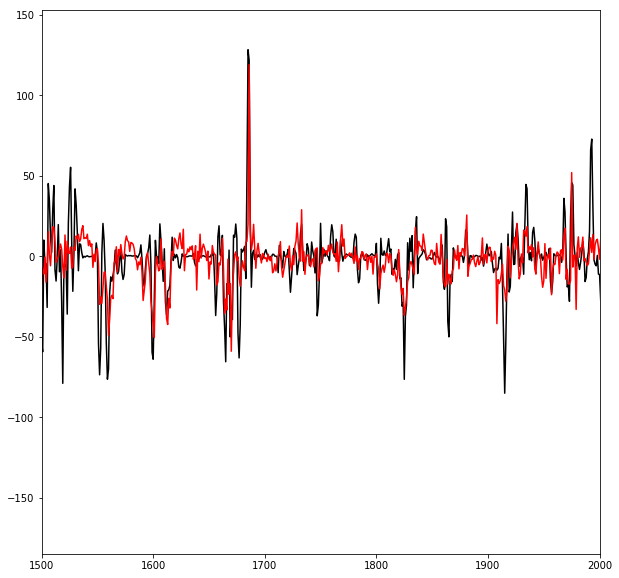

In [97]:
plt.figure(figsize=(10,10))
plt.plot(fictracs['Z'],color='k')
plt.plot(predicted_behavior,color='r')
plt.xlim(1500,2000)

(1500, 2000)

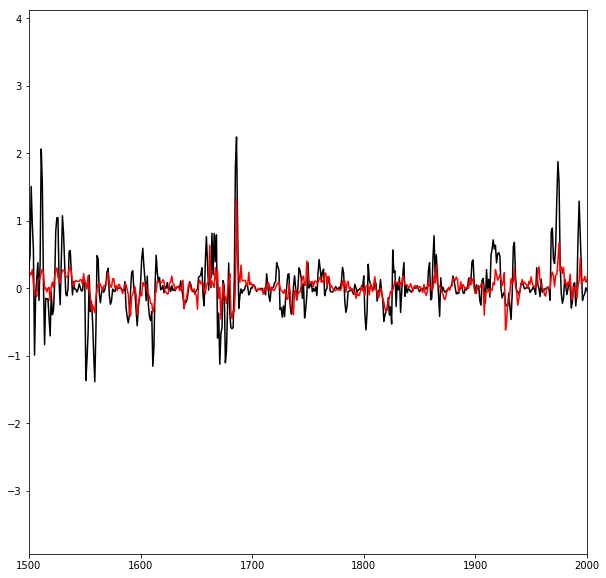

In [93]:
plt.figure(figsize=(10,10))
plt.plot(fictracs['Y'],color='k')
plt.plot(predicted_behavior,color='r')
plt.xlim(1500,2000)

(500, 2000)

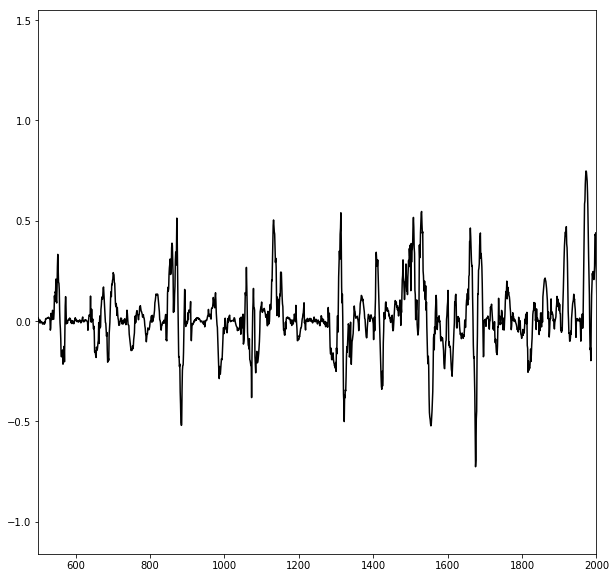

In [85]:
plt.figure(figsize=(10,10))
to_plot = fictracs['Y']
plt.plot(to_plot,color='k')
#plt.plot(predicted_behavior,color='r')
plt.xlim(500,2000)

(1500, 2000)

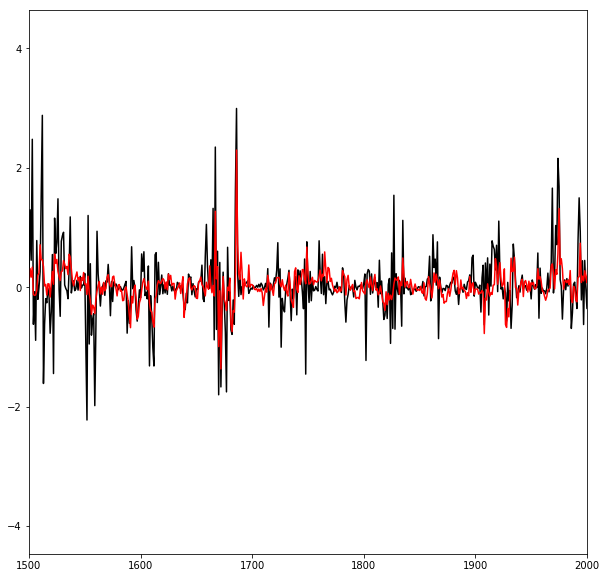

In [69]:
plt.figure(figsize=(10,10))
plt.plot(fictracs['Y'],color='k')
plt.plot(predicted_behavior,color='r')
plt.xlim(1500,2000)

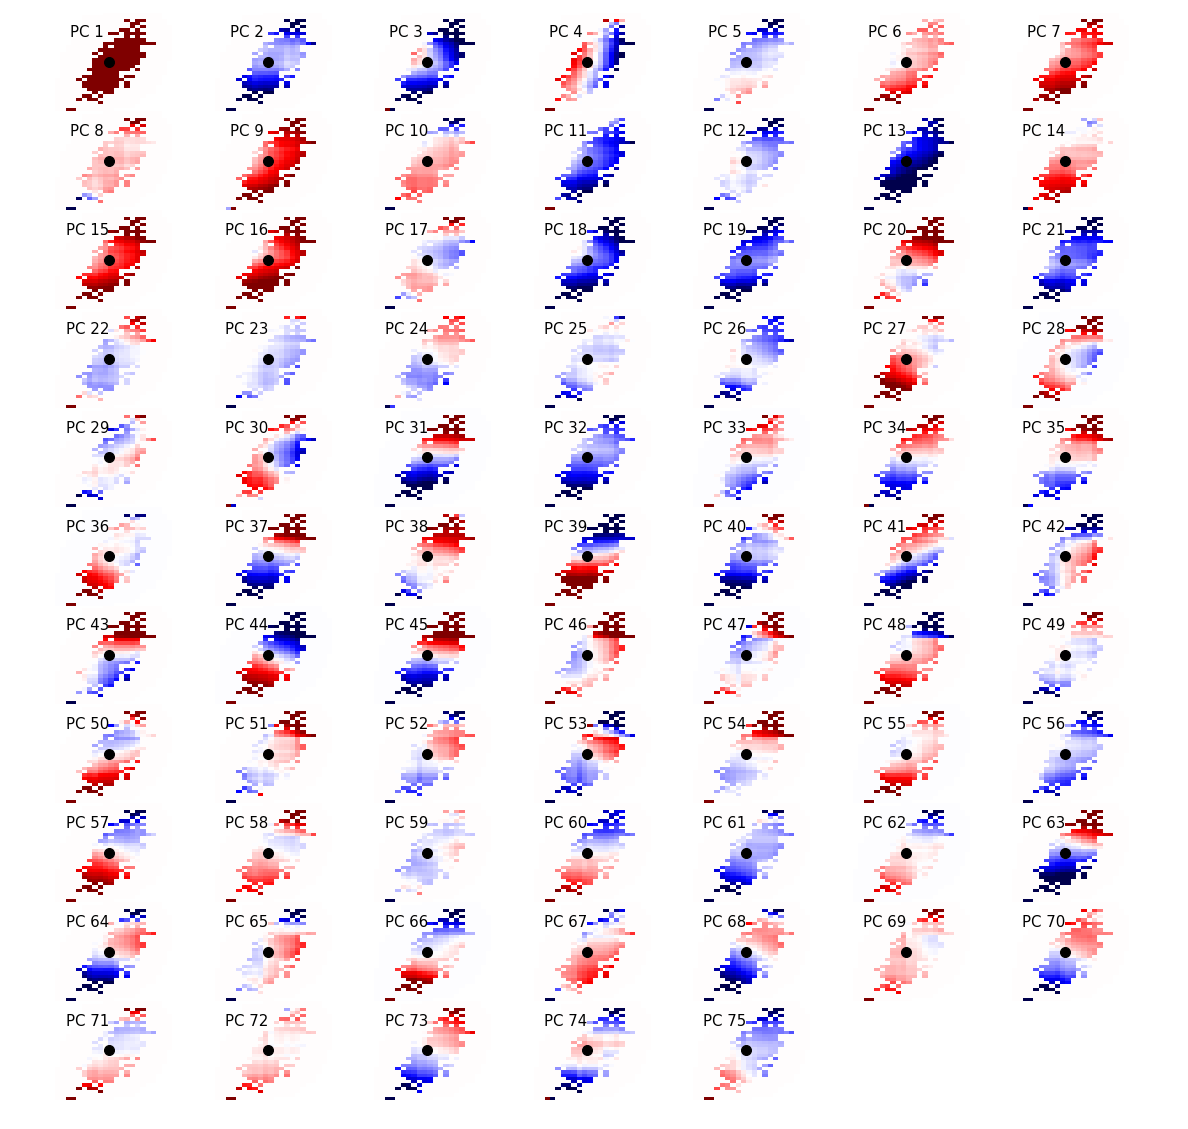

In [82]:
# Bin PCs into behavior bins

# For each bin in the histogram, it has collected several points from across time.
# Find those frame numbers.
# Then, get average value of PC across those timepoints!

def bin_pc(pc, num_bins_x, num_bins_y, idx_x ,idx_y):
    pc_binned = []
    pc_std = []
    pc_count = []
    pc_var = []
    for i in range(num_bins_x):
        mask_x = (idx_x == i)
        for j in range(num_bins_y):
            mask_y = (idx_y == j)
            mask = mask_x & mask_y
            pc_binned.append(np.mean(pc[mask]))
            pc_std.append(np.std(pc[mask]))
            pc_count.append(np.count_nonzero(~np.isnan(pc[mask])))
            pc_var.append(np.var(pc[mask]))
    pc_binned = np.flip(np.reshape(pc_binned,(num_bins_x, num_bins_y)).T,0)
    pc_std = np.flip(np.reshape(pc_std,(num_bins_x, num_bins_y)).T,0)
    pc_count = np.flip(np.reshape(pc_count,(num_bins_x, num_bins_y)).T,0)
    pc_var = np.flip(np.reshape(pc_var,(num_bins_x, num_bins_y)).T,0)
    pcs_binned = {'pc_binned': pc_binned,
                  'pc_std': pc_std,
                  'pc_count':pc_count,
                  'pc_var':pc_var}
    return pcs_binned

def smooth_with_nans(U):
    mode = 'reflect'
    truncate = 1
    sigma = 5

    V=U.copy()
    V[np.isnan(U)]=0
    VV=sp.ndimage.gaussian_filter(V,sigma=sigma,mode=mode,truncate=truncate)

    W=0*U.copy()+1
    W[np.isnan(U)]=0
    WW=sp.ndimage.gaussian_filter(W,sigma=sigma,mode=mode,truncate=truncate)

    Z=VV/WW
    return Z

#### Create behavior bins and get indicies

num_bins_x, num_bins_y = 30, 30
start_x, end_x = -5, 10
start_y, end_y = -200, 200

#start_x, end_x = -10, 15
#start_y, end_y = -130, 130

# Define bins
bins_x, bins_y = np.linspace(start_x,end_x,num_bins_x), np.linspace(start_y,end_y,num_bins_y)

# Assign fictrac values to bin numbers
idx_x, idx_y = np.digitize(fictracs['Y'],bins_x), np.digitize(fictracs['Z'],bins_y)

#### Bin PCs

pcs_binned = []
for i in range(75):
    pcs_binned.append(bin_pc(pca_loadings[:,i], num_bins_x, num_bins_y, idx_x ,idx_y))

#### Plot

plt.figure(figsize=(20,20))
#norm = mpl.colors.LogNorm()
norm = None
contrast = 2
plt.rcParams.update({'font.size': 15})
pc_behavior_plots = []

for i in range(75):
    ax = plt.subplot(11,7,i+1)
    
    pc_bin_smooth = smooth_with_nans(pcs_binned[i]['pc_binned'])
    pc_std_smooth = smooth_with_nans(pcs_binned[i]['pc_std'])
    
    mask = ~np.isnan(pcs_binned[i]['pc_binned'])
    z_score = np.divide(pc_bin_smooth,pc_std_smooth)
    z_score_masked = np.multiply(z_score, mask)
    
    interp_mode = None
    ax.imshow(z_score_masked,
              cmap='seismic',
              aspect='auto',
              extent=(start_x,end_x,start_y,end_y),
              interpolation=interp_mode,
              norm=norm,
              vmin=-1,
              vmax=1)

    plt.scatter(0,0,100,color='k')
    ax.axis('off')
    ax.text(.2, .8,
             'PC {}'.format(i+1),
             horizontalalignment='center',
             verticalalignment='center',
             transform = ax.transAxes)
    pc_behavior_plots.append(z_score_masked)

plt.subplots_adjust(wspace=0, hspace=0)

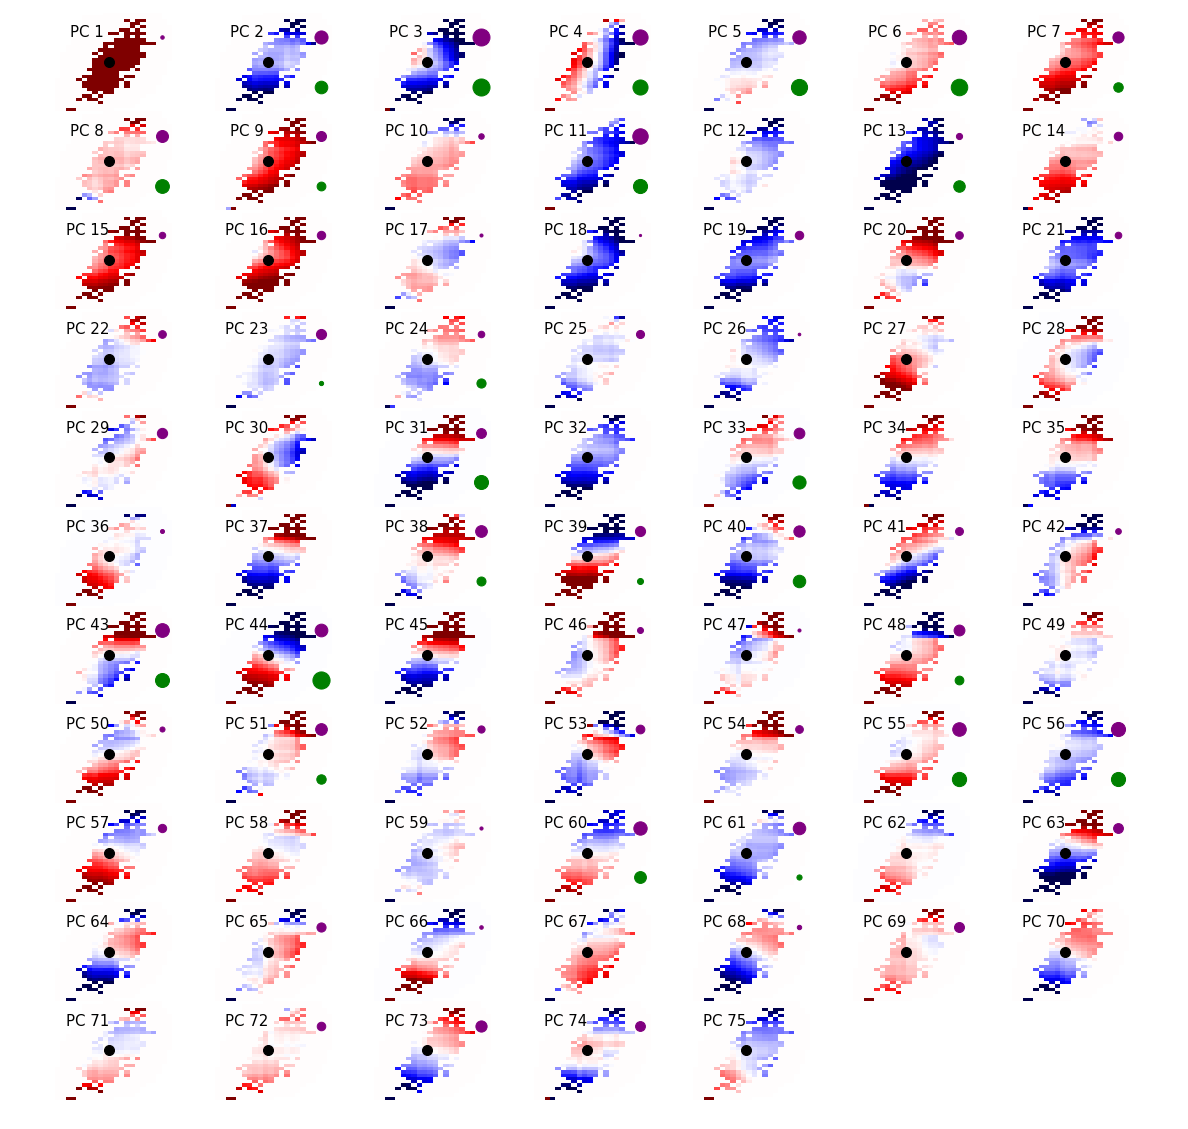

In [83]:
#### Plot

plt.figure(figsize=(20,20))
#norm = mpl.colors.LogNorm()
norm = None
contrast = 2
plt.rcParams.update({'font.size': 15})
pc_behavior_plots = []

for i in range(75):
    ax = plt.subplot(11,7,i+1)
    
    pc_bin_smooth = smooth_with_nans(pcs_binned[i]['pc_binned'])
    pc_std_smooth = smooth_with_nans(pcs_binned[i]['pc_std'])
    
    mask = ~np.isnan(pcs_binned[i]['pc_binned'])
    z_score = np.divide(pc_bin_smooth,pc_std_smooth)
    z_score_masked = np.multiply(z_score, mask)
    
    interp_mode = None
    ax.imshow(z_score_masked,
              cmap='seismic',
              aspect='auto',
              extent=(start_x,end_x,start_y,end_y),
              interpolation=interp_mode,
              norm=norm,
              vmin=-1,
              vmax=1)

    plt.scatter(0,0,100,color='k')
    plt.scatter(5,100,abs(Y_coef)[i]*100,color='purple') # Y
    plt.scatter(5,-100,abs(Z_coef)[i]*100,color='green') # Z
    ax.axis('off')
    ax.text(.2, .8,
             'PC {}'.format(i+1),
             horizontalalignment='center',
             verticalalignment='center',
             transform = ax.transAxes)
    pc_behavior_plots.append(z_score_masked)

plt.subplots_adjust(wspace=0, hspace=0)